In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import nest
import parametersets
from mesocircuit import mesocircuit_framework as mesoframe


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: Sep 12 2022 04:40:40

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
# full-scale parameters
name = 'mesocircuit_MAMV1'
custom_params = parametersets.ps_dicts[name]
meso_exp = mesoframe.MesocircuitExperiment(name, custom_params)

Instantiating MesocircuitExperiment: mesocircuit_MAMV1
Data directory: /home/senk/repositories/mesocircuit-model/scripts/mesocircuit_data/mesocircuit_MAMV1
Evaluating parameters for ps_id: be157ce8d36251d5e2e6a30ba1c8f603
LD_PRELOAD skipped because jemalloc is not in PATH.
Parameterspace mesocircuit_MAMV1 has dimension 0. Hashes are not printed.


In [3]:
net_dict = meso_exp.circuits[0].net_dict

In [4]:
net_dict['num_neurons']

array([ 758176,  213856, 1126192,  281552,  331840,   72864,  317424,
         65008,   14432])

In [5]:
net_dict['indegrees']

array([[1459,  573,  662,  253,  106,    0,   78,    0,    0],
       [1472,  419,  356,  144,  188,    0,   29,    0,    0],
       [ 105,   19,  753,  425,   23,    0,  445,    0,   92],
       [ 733,    9,  895,  834,    7,    0,  797,    0,   57],
       [1432,  201,  767,   18,  280,  227,  197,    0,    0],
       [ 580,   79,  289,    5,  149,  190,   65,    0,    0],
       [ 219,   22,  312,   51,  191,   12,  395,  296,   47],
       [ 377,    3,   33,    3,   69,    4,  367,  201,   18]])

In [6]:
net_dict['ext_indegrees']

array([1918, 1640, 1838, 3116, 1788, 1637, 1904, 1545])

In [7]:
# simulation parameters
T = 1000.                  # simulation time (ms)
dt = 0.1                   # simulation resolution (ms)

N_scaling = 0.01
K_scaling = 1.

# network parameters
N_L6E = int(net_dict['num_neurons'][6] * N_scaling) #4850               # number of neurons in L5E
N_L6I = int(net_dict['num_neurons'][7] * N_scaling) #1065               # number of neurons in L5I
    
Ksyn_L6E_L6E = int(2038173 / N_L6E)     # number of synapses with presynaptic neuron (pre) in L5E and postsynaptic neuron (post) in L5E 
Ksyn_L6E_L6I = int(319602 / N_L6I)   # number of synapses with pre in L5E and post in L5I
Ksyn_L6I_L6I = int(430775 / N_L6I)     # number of synapses with pre in L5I and post in L5I
Ksyn_L6I_L6E = int(2411184 / N_L6E)     # number of synapses with pre in L5I and post in L5E

K_L6E_ext = 2000           # indegree of excitatory neurons to external poisson drive
K_L6I_ext = 1900           # indegree of inhibitory neurons to external poisson drive

# neuron parameters
neuron_params = {
    'C_m'       : 250.,    # pF
    'I_e'       : 0.0,     # nA
    'tau_m'     : 10.0,    # ms
    't_ref'     : 2.0,     # ms
    'tau_syn_ex': 0.5,     # ms
    'tau_syn_in': 0.5,     # ms
    'V_reset'   : -65.0,   # mV
    'E_L'       : -65.0,   # mV
    'V_th'      : -50.0    # mV
}

# synapse parameters
w = 87.8                   # mean excitatory weight (pA)
sigma_w = 8.8              # standard deviation of excitatory weight (pA)
g = -4.                    # relative inhibitory weight 

de = 1.5                   # mean spike transmission delay for excitatory presynaptic neurons (ms)
sigma_de = 0.75            # standard deviation 
di = 0.8                   # mean spike transmission delay for inhibitory presynaptic neurons (ms)
sigma_di = 0.4             # standard deviation
 
# input parameters
bg_rate = 8.               # external poisson rate

In [8]:
print(Ksyn_L6E_L6E, Ksyn_L6E_L6I, Ksyn_L6I_L6I, Ksyn_L6I_L6E)

642 491 662 759


In [9]:
nest.ResetKernel()
nest.resolution = dt      # set simulation resolution


Apr 25 19:31:25 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


In [10]:
# create excitatory and inhibitory neuron populations
pop_L6E = nest.Create('iaf_psc_exp', N_L6E)
nest.SetStatus(pop_L6E, params=neuron_params)

pop_L6I = nest.Create('iaf_psc_exp', N_L6I, params=neuron_params)

In [11]:
# excitatory connections (connections from L5E)

# specifying the synapse parameters
syn_dict = {
    'synapse_model': 'static_synapse',
    'weight': nest.math.redraw(
        nest.random.normal(
            mean=w,
            std=sigma_w),
        min=0,
        max=np.Inf),
    'delay': nest.math.redraw(
                nest.random.normal(
            mean=de,
            std=sigma_de),
        min=nest.resolution, # TODO
        max=np.Inf)
}

# connections to L5E
# specifying the connection parameters
conn_dict = {'rule': 'fixed_indegree', 'indegree': Ksyn_L6E_L6E}
nest.Connect(pop_L6E, pop_L6E, conn_dict, syn_dict)

# connections to L5I
conn_dict = {'rule': 'fixed_indegree', 'indegree': Ksyn_L6E_L6I}
nest.Connect(pop_L6E, pop_L6I, conn_dict, syn_dict)

In [12]:

# inhibitory connections (connections from L5I)

# specifying the synapse parameters
syn_dict = {
    'synapse_model': 'static_synapse',
    'weight': nest.math.redraw(
        nest.random.normal(
            mean=g*w,
            std=np.abs(g*sigma_w)),
        min=-np.Inf,
        max=0),
    'delay': nest.math.redraw(
                nest.random.normal(
            mean=di,
            std=sigma_di),
        min=nest.resolution, # TODO
        max=np.Inf)
}

# connections to L5E
# specifying the connection parameters
conn_dict = {'rule': 'fixed_indegree', 'indegree': Ksyn_L6I_L6E}
nest.Connect(pop_L6I, pop_L6E, conn_dict, syn_dict)

# connections to L5I
conn_dict = {'rule': 'fixed_indegree', 'indegree': Ksyn_L6I_L6I}
nest.Connect(pop_L6I, pop_L6I, conn_dict, syn_dict)
     

In [13]:
# connections with external poisson generator

# connections to L5E
poisson_generator_L6E = nest.Create('poisson_generator',
                                    params={'rate': bg_rate*K_L6E_ext})
nest.Connect(poisson_generator_L6E, pop_L6E, 'all_to_all', {'weight': w, 'delay': de})

# connections to L5I
poisson_generator_L6I = nest.Create('poisson_generator',
                                    params={'rate': bg_rate*K_L6I_ext})
nest.Connect(poisson_generator_L6I, pop_L6I, 'all_to_all', {'weight': w, 'delay': de})

In [14]:
# set up and connect spike detector
sd_L6E = nest.Create('spike_recorder')
nest.Connect(pop_L6E, sd_L6E, 'all_to_all')

sd_L6I = nest.Create('spike_recorder')
nest.Connect(pop_L6I, sd_L6I, 'all_to_all')

In [15]:
# run simulation
nest.Simulate(T)    


Apr 25 19:31:27 NodeManager::prepare_nodes [Info]: 
    Preparing 3828 nodes for simulation.

Apr 25 19:31:27 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3828
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Apr 25 19:31:32 SimulationManager::run [Info]: 
    Simulation finished.


In [16]:
# read out recorded spikes
spike_senders_L6E = nest.GetStatus(sd_L6E)[0]['events']['senders']
spike_times_L6E = nest.GetStatus(sd_L6E)[0]['events']['times']
spike_senders_L6I = nest.GetStatus(sd_L6I)[0]['events']['senders']
spike_times_L6I = nest.GetStatus(sd_L6I)[0]['events']['times']

spike_senders = np.hstack((spike_senders_L6E, spike_senders_L6I))
spike_times = np.hstack((spike_times_L6E, spike_times_L6I))

Text(0, 0.5, 'neuron id')

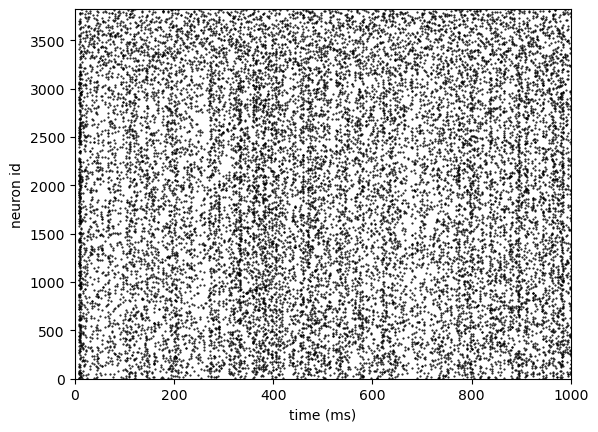

In [17]:
# plotting
plt.plot(spike_times, spike_senders, 'k.', markersize=1)
plt.xlim(0, T)
plt.ylim(0, N_L6E+N_L6I)
plt.xlabel('time (ms)')
plt.ylabel('neuron id')

In [18]:
# compute average firing rate
rate_E = nest.GetStatus(sd_L6E)[0]['n_events']/T*1e3/N_L6E
print(f'Firing rate E = {rate_E:.2f} spikes/s')

rate_I = nest.GetStatus(sd_L6I)[0]['n_events']/T*1e3/N_L6I
print(f'Firing rate I = {rate_I:.2f} spikes/s')
     


Firing rate E = 4.32 spikes/s
Firing rate I = 4.72 spikes/s
